# DNN: analysis with Keras of 2D data

In [ ]:
import numpy as np #Always usefull and to be used

from keras.models import Sequential
from keras.layers import Dense, Dropout

from useful import *

import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

%run useful.py

# training data
perc_train = 0.8

## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


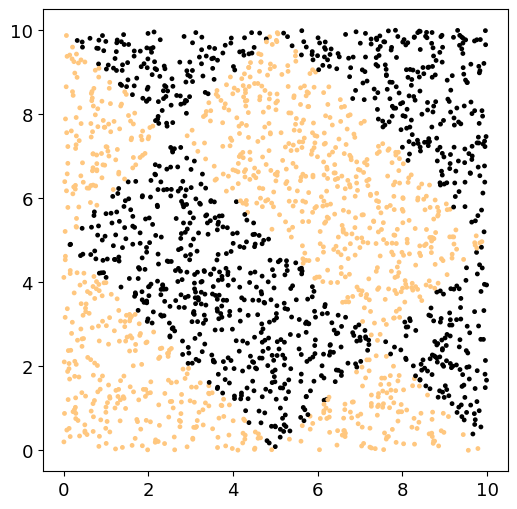

In [2]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [3]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [4]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1600 	 Validation: 400


# Augmentation

In [ ]:
max_array = [ max( x_train[:,i] ) for i in range(L) ]
min_array = [ min( x_train[:,i] ) for i in range(L) ]
center_point = []
N = 10000

for j in range(N):
    a = []
    a = [ np.random.uniform( min_array[i], max_array[i] ) for i in range(L)  ]
    center_point.append(a)
center_point = np.array(center_point)
epsilon = 2
thresold = 0.6

x_augum = []
y_augum = []

for i in range(N):
    mask =  np.sqrt( np.sum ( ( x_train - center_point[i,:] ) ** 2, axis = 1)    ) < epsilon
    inside_sphere = y_train[mask]
    if np.mean(inside_sphere) >= thresold or np.mean(inside_sphere) <= (1-thresold):
        
        x_augum.append( center_point[i,:] )
        y_augum.append( round(np.mean(inside_sphere) ) )

x_augum = np.array(x_augum)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[[ 1.46947595  0.36799852  1.49428932 ...  0.26575169  0.42033933
  -1.50173051]
 [-1.06231128  0.19872076 -1.69678796 ... -1.67530893  1.34924067
   0.76016713]
 [-0.87125605  0.17835887  1.06965638 ... -1.04873022 -0.55615551
   0.90880898]
 ...
 [-0.2753286   1.08242906  0.22961122 ... -1.50150127  1.0612737
  -1.28341602]
 [ 1.16112732 -0.54993729 -1.63393783 ... -0.72451294 -1.28065807
  -1.26603822]
 [-1.624699   -1.50548162 -0.45833869 ...  0.38618991 -0.14706471
  -0.1063165 ]]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0

## Define the model with Keras / Tensorflow

In [6]:
# reproducibility (?)
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# We use case 1
CASE=1

if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid')) #sigmoid because we want a result between 0 and 1
    nepoch=400
# as case 1 but one layer shorter
if CASE==2:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(40,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
#deeper
if CASE==3:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
print(model.summary())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

None


## Optimization method and cost function

In [7]:
model.compile(loss='binary_crossentropy', optimizer='RMSprop', #optimizer='adam',
              metrics=['accuracy'])

## Training

In [ ]:
fit = model.fit(x_train, y_train, epochs = nepoch, batch_size = 50, validation_data=(x_valid,y_valid),verbose=0)

Epoch 1/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4688 - loss: 0.7031 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4921 - loss: 0.6976 - val_accuracy: 0.5225 - val_loss: 0.6906
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5141 - loss: 0.6934 - val_accuracy: 0.5375 - val_loss: 0.6906
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.5222 - loss: 0.6933 - val_accuracy: 0.5400 - val_loss: 0.6903
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5176 - loss: 0.6921 - val_accuracy: 0.5475 - val_loss: 0.6896
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5093 - loss: 0.6918 - val_accuracy: 0.5700 - val_loss: 0.6890
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5460 - loss: 0.6883 - val_accuracy: 0.5600 - val_loss: 0.6871
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5346 - loss: 0.6870 - val_accura

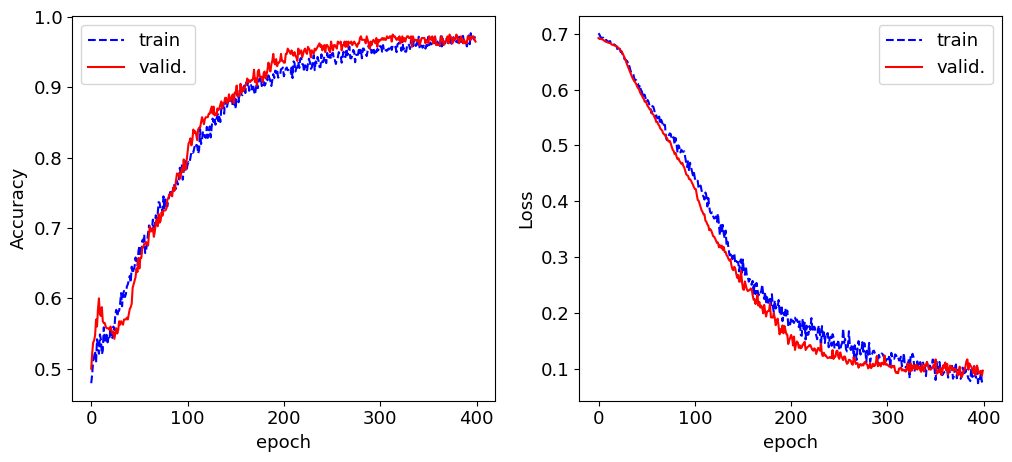

In [9]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


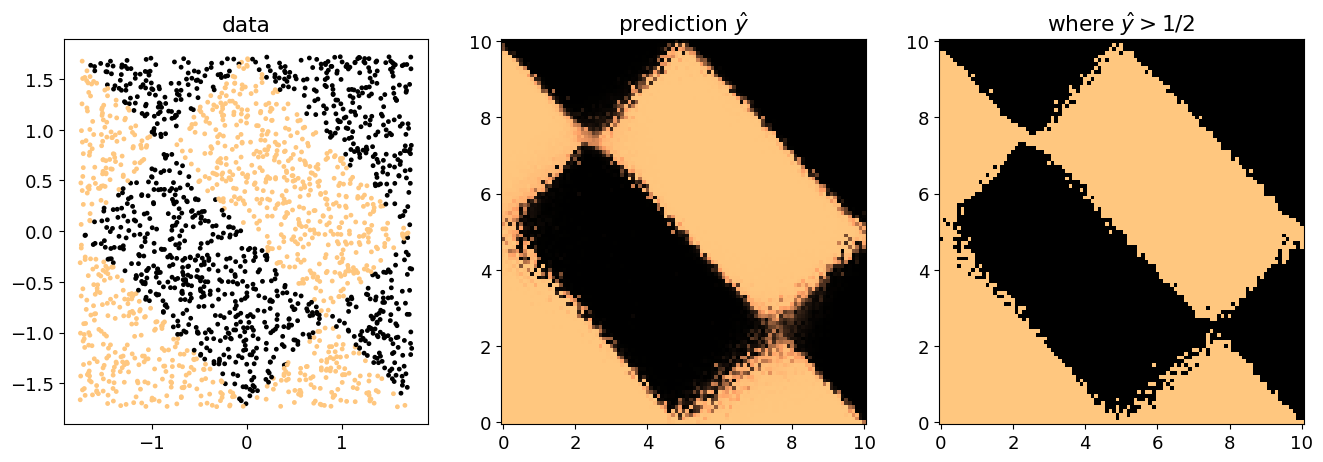

remember: these are 2 out of L=8 dimensions, of which L-2 contain random noise


In [10]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these are 2 out of L={L} dimensions, of which L-2 contain random noise")

In [ ]:
import keras_tuner
import keras
from keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=10, max_value=30, step=5),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "elu"]),
            )
        )
        model.add(layers.Dropout(rate=hp.Float("dropout", min_value = 0, max_value = 0.2, step = 0.05)))
        
    model.add(layers.Dense(1, activation="sigmoid")) #Layer output --> importante che sia della size giusta
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "RMSprop", "Nesterov"]), loss="binary_crossentropy",
        metrics=["accuracy"])
    return model


build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
)

tuner.search_space_summary()

tuner.search(x_train, y_train, batch_size = 50, epochs = 320, validation_data=(x_valid,y_valid), verbose=1)

Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.6324999928474426
Total elapsed time: 00h 00m 13s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
2                 |4                 |num_layers
20                |30                |units_0
elu               |sigmoid           |activation
0.2               |0.2               |dropout
0.00018438        |0.0032511         |lr
RMSprop           |adam              |optimizer
25                |10                |units_1
25                |10                |units_2
15                |10                |units_3

Epoch 1/320
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5343 - loss: 0.7192 - val_accuracy: 0.5500 - val_loss: 0.6937
Epoch 2/320
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5165 - loss: 0.7099 - val_accuracy: 0.5375 - val_loss: 0.6853
Epoch 3/320
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5564 - loss: 0.6899 - val_accuracy: 0.5325 - val_loss: 0.6801
Epoch 4/

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


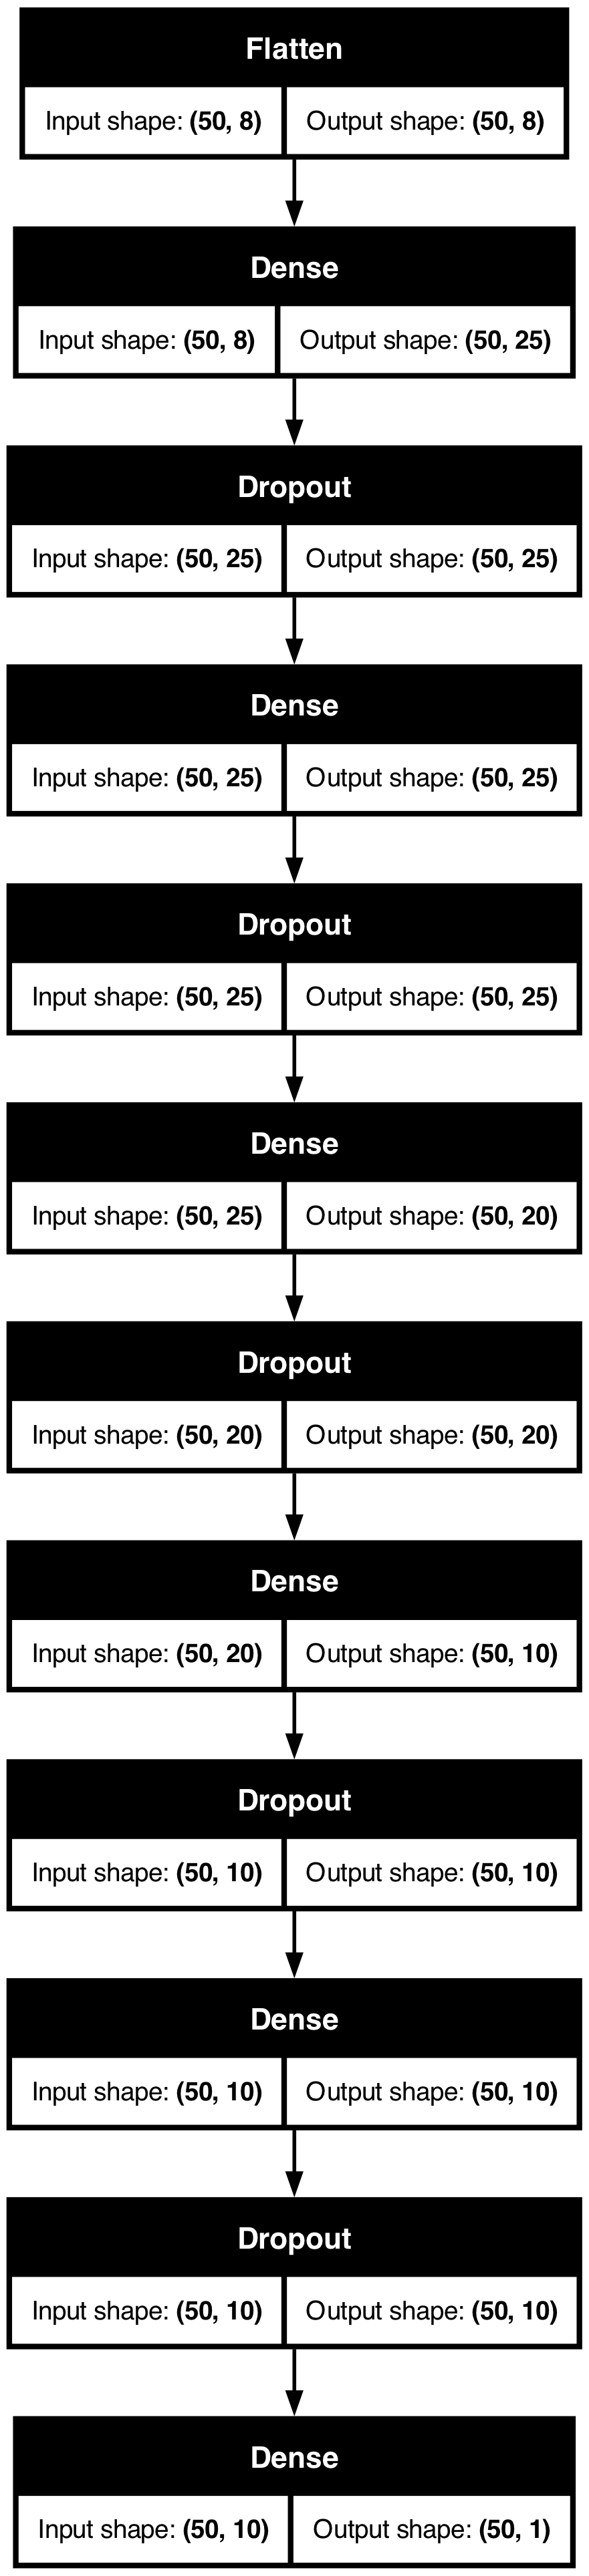

In [ ]:
#A way to visualize the NN
model = tuner.get_best_models(num_models=1)
keras.utils.plot_model(model[0], show_shapes=True)